In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import json

# Data Preprocessing

In [2]:
# We resize the input images, convert them to tensors and normalize them to [-1,1]
transform = transforms.Compose([
    transforms.Resize((128, 128)),   # Resize images to 128x128
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Augmented transform
augmented_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
train_dir = '/kaggle/input/inaturalist-1/inaturalist_12K/train'
test_dir = '/kaggle/input/inaturalist-1/inaturalist_12K/val'

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)



In [4]:
# Load the full training dataset
full_train_dataset = ImageFolder(root=train_dir, transform=transform)

# Calculate split sizes
val_size = int(0.2 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load the test set
test_dataset = ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [5]:
#Make sure every class is represented equally in validation data

from collections import Counter
import matplotlib.pyplot as plt

# Get original dataset labels (from the subset indices)
val_targets = [full_train_dataset.targets[i] for i in val_dataset.indices]

# Count frequency of each class
val_class_counts = Counter(val_targets)

print(sorted(val_class_counts.items()))

[(0, 189), (1, 211), (2, 196), (3, 183), (4, 197), (5, 195), (6, 189), (7, 212), (8, 224), (9, 203)]


In [6]:
num_classes = len(full_train_dataset.classes)

class CNN(nn.Module):
    def __init__(self, num_classes, conv_filters=[96, 256, 384, 384, 256], kernel_sizes=[3, 3, 3, 3, 3], activation_fn=F.relu, fc_units=[1024],dropout=[0.0],
        use_batchnorm=False):
        super(CNN, self).__init__()
        
        
        assert len(conv_filters) == len(kernel_sizes), "conv_filters and kernel_sizes must be the same length"
        
        self.activation_fn = activation_fn
        self.use_batchnorm = use_batchnorm

        self.pool = nn.MaxPool2d(2, 2)
        
        
        self.conv_layers = nn.ModuleList()
        self.batchnorm_layers = nn.ModuleList()


        in_channels = 3  
        for out_channels, kernel_size in zip(conv_filters, kernel_sizes):
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2))
            
            if use_batchnorm:
                self.batchnorm_layers.append(nn.BatchNorm2d(out_channels))
            
            in_channels = out_channels  
        
        
        # Dynamically compute the flattened size 
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 128, 128)  
            x = dummy_input
            for idx, conv in enumerate(self.conv_layers):
                x = conv(x)
                if self.use_batchnorm:
                    x = self.batchnorm_layers[idx](x)
                x = self.activation_fn(x)
                x = self.pool(x)
            self.flattened_size = x.view(1, -1).size(1)


        # Only one dense layer
        self.fc = nn.Linear(self.flattened_size, fc_units[0])
        self.dropout = nn.Dropout(dropout)

        # Final output layer
        self.fc_out = nn.Linear(fc_units[0], num_classes)
    
    def forward(self, x):
        for idx, conv in enumerate(self.conv_layers):
            x = conv(x)
            if self.use_batchnorm:
                x = self.batchnorm_layers[idx](x)
            x = self.activation_fn(x)
            x = self.pool(x)

        x = torch.flatten(x, 1)
        
        x = self.activation_fn(self.fc(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = CNN(num_classes, conv_filters=[64, 128, 256, 256, 128], kernel_sizes=[5, 3, 3, 3, 3], activation_fn=F.leaky_relu, fc_units=[512, 256]).to(device)

In [8]:
import wandb


In [9]:
activation_map = {
    'relu': F.relu,
    'gelu': F.gelu,
    'silu': F.silu,
    'mish': F.mish
}

In [10]:
def train(config=None):
    with wandb.init(config=config) as run:
        config = wandb.config
        
        run.name = f"filters={config.conv_filters}_act={config.activation_fn}_aug={config.use_augmentation}_bn={config.use_batchnorm}_dropout={config.dropout}"
        run.save()

        # Choose transform for training
        if config.use_augmentation:
            train_transform = augmented_transform
        else:
            train_transform = transform

        # Load full dataset with chosen transform
        full_train_dataset = ImageFolder(train_dir, transform=train_transform)

        # Split into train and val
        val_size = int(0.2 * len(full_train_dataset))
        train_size = len(full_train_dataset) - val_size
        train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

        # Set val transform to basic (no augmentation)
        val_dataset.dataset.transform = transform

        # Data loaders
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)


        # Model instantiation 
        model = CNN(
                  num_classes=num_classes,
                  conv_filters=config.conv_filters,
                  kernel_sizes=[3] * len(config.conv_filters), #why 3?
                  activation_fn=activation_map[config.activation_fn],
                  fc_units=config.fc_units,
                  dropout=config.dropout,
                  use_batchnorm=config.use_batchnorm
              ).to(device)

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

        
        best_val_acc = 0.0

        for epoch in range(config.epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_loss = running_loss / len(train_loader)
            train_acc = 100 * correct_train / total_train

            # Validation phase
            model.eval()
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = model(val_inputs)
                    _, val_predicted = torch.max(val_outputs.data, 1)
                    total_val += val_labels.size(0)
                    correct_val += (val_predicted == val_labels).sum().item()

            val_acc = 100 * correct_val / total_val
            model.train()

            print(f"Epoch {epoch+1}/{config.epochs}")
            print(f"  Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.2f}%")
            print(f"  Validation Accuracy: {val_acc:.2f}%\n")

            # Save best model and config
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), "best_model.pth")
                with open("best_config.json", "w") as f:
                    json.dump(dict(config), f)

            # Log metrics to W&B
            wandb.log({
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_acc": val_acc
            })

        # Test accuracy (do not log to W&B)
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
                test_outputs = model(test_inputs)
                _, test_preds = torch.max(test_outputs.data, 1)
                total_test += test_labels.size(0)
                correct_test += (test_preds == test_labels).sum().item()

        test_acc = 100 * correct_test / total_test
        print(f"Final Test Accuracy: {test_acc:.2f}%")


In [11]:
sweep_config = {
    'method': 'bayes',  
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'lr': {
            'values': [0.001, 0.0005, 0.0001]
        },
        'epochs': {
            'values': [5,10]
        },
        'conv_filters': {
            'values': [
                [32, 64, 128, 256, 512],
                [64, 128, 256, 512, 1024],
                [32, 64, 64, 128, 128],
                [128, 128, 128, 128, 128],
                [1024,512,256,128,64]
            ]
        },
        'activation_fn': {
            'values': ['relu', 'gelu', 'silu', 'mish']
        },
        'fc_units': {
            'values': [[256],[512],[1024],]
        },
        'batch_size': {'values': [32, 64]},
        'use_batchnorm': {'values': [True, False]},
        'use_augmentation': {'values': [True, False]},
        'dropout': {'values': [0,0.1,0.2,0.3,0.5]}

    }
}


In [12]:
wandb.login(key='af7d7cf29d8954a13afb06c7a0d0c196c36ac51b')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ma24m003 (ma24m003-iit-madras). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [13]:
# Create sweep
sweep_id = wandb.sweep(sweep_config, project="inaturalist-hyperparam-tuning")

# Launch sweep agents
wandb.agent(sweep_id, function=train, count=10)  # runs 10 experiments

wandb.finish()


Create sweep with ID: py6a62bt
Sweep URL: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning/sweeps/py6a62bt


wandb: Agent Starting Run: 6si794ig with config:
wandb: 	activation_fn: silu
wandb: 	batch_size: 32
wandb: 	conv_filters: [1024, 512, 256, 128, 64]
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	fc_units: [512]
wandb: 	lr: 0.001
wandb: 	use_augmentation: False
wandb: 	use_batchnorm: True
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250413_104400-6si794ig
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run morning-sweep-1
wandb: ⭐️ View project at https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning
wandb: 🧹 View sweep at https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning/sweeps/py6a62bt
wandb: 🚀 View run at https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning/runs/6si794ig
wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Epoch 1/5
  Training Loss: 2.1288 | Training Accuracy: 22.15%
  Validation Accuracy: 25.16%

Epoch 2/5
  Training Loss: 1.9833 | Training Accuracy: 28.81%
  Validation Accuracy: 27.16%

Epoch 3/5
  Training Loss: 1.8988 | Training Accuracy: 33.05%
  Validation Accuracy: 29.96%

Epoch 4/5
  Training Loss: 1.8184 | Training Accuracy: 35.79%
  Validation Accuracy: 32.57%

Epoch 5/5
  Training Loss: 1.7293 | Training Accuracy: 38.15%
  Validation Accuracy: 30.77%

Final Test Accuracy: 31.60%


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  train_acc ▁▄▆▇█
wandb: train_loss █▅▄▃▁
wandb:    val_acc ▁▃▆█▆
wandb: 
wandb: Run summary:
wandb:  train_acc 38.15
wandb: train_loss 1.72929
wandb:    val_acc 30.76538
wandb: 
wandb: 🚀 View run filters=[1024, 512, 256, 128, 64]_act=silu_aug=False_bn=True_dropout=0.2 at: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning/runs/6si794ig
wandb: ⭐️ View project at: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250413_104400-6si794ig/logs
wandb: Agent Starting Run: 7f9afnev with config:
wandb: 	activation_fn: silu
wandb: 	batch_size: 64
wandb: 	conv_filters: [32, 64, 64, 128, 128]
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	fc_units: [256]
wandb: 	lr: 0.0001
wandb: 	use_augmentation: False
wandb: 	use_batchnorm:

Epoch 1/10
  Training Loss: 2.1194 | Training Accuracy: 23.62%
  Validation Accuracy: 27.26%

Epoch 2/10
  Training Loss: 1.9375 | Training Accuracy: 31.75%
  Validation Accuracy: 32.17%

Epoch 3/10
  Training Loss: 1.8405 | Training Accuracy: 35.92%
  Validation Accuracy: 33.87%

Epoch 4/10
  Training Loss: 1.7576 | Training Accuracy: 38.67%
  Validation Accuracy: 35.77%

Epoch 5/10
  Training Loss: 1.6663 | Training Accuracy: 41.96%
  Validation Accuracy: 33.77%

Epoch 6/10
  Training Loss: 1.5688 | Training Accuracy: 46.60%
  Validation Accuracy: 35.27%

Epoch 7/10
  Training Loss: 1.4821 | Training Accuracy: 49.26%
  Validation Accuracy: 36.42%

Epoch 8/10
  Training Loss: 1.3728 | Training Accuracy: 53.20%
  Validation Accuracy: 37.12%

Epoch 9/10
  Training Loss: 1.2429 | Training Accuracy: 58.16%
  Validation Accuracy: 33.57%

Epoch 10/10
  Training Loss: 1.1223 | Training Accuracy: 62.80%
  Validation Accuracy: 37.97%

Final Test Accuracy: 38.55%


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  train_acc ▁▂▃▄▄▅▆▆▇█
wandb: train_loss █▇▆▅▅▄▄▃▂▁
wandb:    val_acc ▁▄▅▇▅▆▇▇▅█
wandb: 
wandb: Run summary:
wandb:  train_acc 62.8
wandb: train_loss 1.12233
wandb:    val_acc 37.96898
wandb: 
wandb: 🚀 View run filters=[32, 64, 64, 128, 128]_act=silu_aug=False_bn=True_dropout=0.5 at: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning/runs/7f9afnev
wandb: ⭐️ View project at: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250413_105841-7f9afnev/logs
wandb: Agent Starting Run: 394c2so2 with config:
wandb: 	activation_fn: mish
wandb: 	batch_size: 32
wandb: 	conv_filters: [128, 128, 128, 128, 128]
wandb: 	dropout: 0.5
wandb: 	epochs: 5
wandb: 	fc_units: [512]
wandb: 	lr: 0.0001
wandb: 	use_augmentation: True
wandb: 	us

Epoch 1/5
  Training Loss: 2.1000 | Training Accuracy: 23.94%
  Validation Accuracy: 30.47%

Epoch 2/5
  Training Loss: 1.9247 | Training Accuracy: 31.84%
  Validation Accuracy: 31.87%

Epoch 3/5
  Training Loss: 1.8265 | Training Accuracy: 36.12%
  Validation Accuracy: 34.07%

Epoch 4/5
  Training Loss: 1.7360 | Training Accuracy: 39.38%
  Validation Accuracy: 37.77%

Epoch 5/5
  Training Loss: 1.6280 | Training Accuracy: 43.16%
  Validation Accuracy: 37.42%

Final Test Accuracy: 37.70%


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  train_acc ▁▄▅▇█
wandb: train_loss █▅▄▃▁
wandb:    val_acc ▁▂▄██
wandb: 
wandb: Run summary:
wandb:  train_acc 43.1625
wandb: train_loss 1.628
wandb:    val_acc 37.41871
wandb: 
wandb: 🚀 View run filters=[128, 128, 128, 128, 128]_act=mish_aug=True_bn=True_dropout=0.5 at: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning/runs/394c2so2
wandb: ⭐️ View project at: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250413_110845-394c2so2/logs
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vot8yjss with config:
wandb: 	activation_fn: mish
wandb: 	batch_size: 32
wandb: 	conv_filters: [64, 128, 256, 512, 1024]
wandb: 	dropout: 0.5
wandb: 	epochs: 5
wandb: 	fc_units: [256]
wandb: 	lr: 0.

Epoch 1/5
  Training Loss: 2.1722 | Training Accuracy: 20.57%
  Validation Accuracy: 27.16%

Epoch 2/5
  Training Loss: 2.0496 | Training Accuracy: 27.41%
  Validation Accuracy: 29.66%

Epoch 3/5
  Training Loss: 1.9707 | Training Accuracy: 31.01%
  Validation Accuracy: 29.31%

Epoch 4/5
  Training Loss: 1.9211 | Training Accuracy: 32.39%
  Validation Accuracy: 32.82%

Epoch 5/5
  Training Loss: 1.8735 | Training Accuracy: 34.54%
  Validation Accuracy: 31.87%

Final Test Accuracy: 33.45%


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  train_acc ▁▄▆▇█
wandb: train_loss █▅▃▂▁
wandb:    val_acc ▁▄▄█▇
wandb: 
wandb: Run summary:
wandb:  train_acc 34.5375
wandb: train_loss 1.87347
wandb:    val_acc 31.86593
wandb: 
wandb: 🚀 View run filters=[64, 128, 256, 512, 1024]_act=mish_aug=False_bn=False_dropout=0.5 at: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning/runs/vot8yjss
wandb: ⭐️ View project at: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250413_111412-vot8yjss/logs
wandb: Agent Starting Run: yeg587kj with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	conv_filters: [64, 128, 256, 512, 1024]
wandb: 	dropout: 0.1
wandb: 	epochs: 10
wandb: 	fc_units: [512]
wandb: 	lr: 0.0001
wandb: 	use_augmentation: True
wandb: 	use_batch

Epoch 1/10
  Training Loss: 2.0850 | Training Accuracy: 25.98%
  Validation Accuracy: 30.47%

Epoch 2/10
  Training Loss: 1.8985 | Training Accuracy: 32.20%
  Validation Accuracy: 29.01%

Epoch 3/10
  Training Loss: 1.8066 | Training Accuracy: 36.40%
  Validation Accuracy: 35.62%

Epoch 4/10
  Training Loss: 1.7037 | Training Accuracy: 39.76%
  Validation Accuracy: 36.32%

Epoch 5/10
  Training Loss: 1.6053 | Training Accuracy: 43.58%
  Validation Accuracy: 37.32%

Epoch 6/10
  Training Loss: 1.4941 | Training Accuracy: 47.60%
  Validation Accuracy: 40.42%

Epoch 7/10
  Training Loss: 1.3612 | Training Accuracy: 52.81%
  Validation Accuracy: 39.27%

Epoch 8/10
  Training Loss: 1.2193 | Training Accuracy: 58.24%
  Validation Accuracy: 43.12%

Epoch 9/10
  Training Loss: 1.0380 | Training Accuracy: 64.55%
  Validation Accuracy: 36.17%

Epoch 10/10
  Training Loss: 0.8280 | Training Accuracy: 72.21%
  Validation Accuracy: 38.97%

Final Test Accuracy: 39.85%


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  train_acc ▁▂▃▃▄▄▅▆▇█
wandb: train_loss █▇▆▆▅▅▄▃▂▁
wandb:    val_acc ▂▁▄▅▅▇▆█▅▆
wandb: 
wandb: Run summary:
wandb:  train_acc 72.2125
wandb: train_loss 0.828
wandb:    val_acc 38.96948
wandb: 
wandb: 🚀 View run filters=[64, 128, 256, 512, 1024]_act=relu_aug=True_bn=True_dropout=0.1 at: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning/runs/yeg587kj
wandb: ⭐️ View project at: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250413_111919-yeg587kj/logs
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: brvabek0 with config:
wandb: 	activation_fn: mish
wandb: 	batch_size: 64
wandb: 	conv_filters: [32, 64, 128, 256, 512]
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	fc_units: [512]


Epoch 1/10
  Training Loss: 2.4338 | Training Accuracy: 17.77%
  Validation Accuracy: 25.76%

Epoch 2/10
  Training Loss: 2.1359 | Training Accuracy: 22.79%
  Validation Accuracy: 24.76%

Epoch 3/10
  Training Loss: 2.0991 | Training Accuracy: 24.48%
  Validation Accuracy: 26.31%

Epoch 4/10
  Training Loss: 2.0554 | Training Accuracy: 25.84%
  Validation Accuracy: 27.61%

Epoch 5/10
  Training Loss: 2.0453 | Training Accuracy: 26.40%
  Validation Accuracy: 30.42%

Epoch 6/10
  Training Loss: 2.0070 | Training Accuracy: 28.19%
  Validation Accuracy: 32.37%

Epoch 7/10
  Training Loss: 1.9803 | Training Accuracy: 28.76%
  Validation Accuracy: 30.47%

Epoch 8/10
  Training Loss: 1.9553 | Training Accuracy: 30.36%
  Validation Accuracy: 33.72%

Epoch 9/10
  Training Loss: 1.9291 | Training Accuracy: 31.20%
  Validation Accuracy: 32.92%

Epoch 10/10
  Training Loss: 1.8970 | Training Accuracy: 32.56%
  Validation Accuracy: 33.87%

Final Test Accuracy: 32.70%


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  train_acc ▁▃▄▅▅▆▆▇▇█
wandb: train_loss █▄▄▃▃▂▂▂▁▁
wandb:    val_acc ▂▁▂▃▅▇▅█▇█
wandb: 
wandb: Run summary:
wandb:  train_acc 32.5625
wandb: train_loss 1.89698
wandb:    val_acc 33.86693
wandb: 
wandb: 🚀 View run filters=[32, 64, 128, 256, 512]_act=mish_aug=False_bn=True_dropout=0.5 at: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning/runs/brvabek0
wandb: ⭐️ View project at: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250413_112952-brvabek0/logs
wandb: Agent Starting Run: fxn1bnth with config:
wandb: 	activation_fn: mish
wandb: 	batch_size: 32
wandb: 	conv_filters: [128, 128, 128, 128, 128]
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	fc_units: [1024]
wandb: 	lr: 0.001
wandb: 	use_augmentation: False
wand

Epoch 1/10
  Training Loss: 2.2348 | Training Accuracy: 18.66%
  Validation Accuracy: 24.26%

Epoch 2/10
  Training Loss: 2.1093 | Training Accuracy: 24.68%
  Validation Accuracy: 24.11%

Epoch 3/10
  Training Loss: 2.0114 | Training Accuracy: 28.51%
  Validation Accuracy: 29.26%

Epoch 4/10
  Training Loss: 1.9400 | Training Accuracy: 30.98%
  Validation Accuracy: 30.32%

Epoch 5/10
  Training Loss: 1.8469 | Training Accuracy: 34.66%
  Validation Accuracy: 34.27%

Epoch 6/10
  Training Loss: 1.7451 | Training Accuracy: 38.90%
  Validation Accuracy: 34.97%

Epoch 7/10
  Training Loss: 1.5929 | Training Accuracy: 43.89%
  Validation Accuracy: 33.87%

Epoch 8/10
  Training Loss: 1.3370 | Training Accuracy: 53.74%
  Validation Accuracy: 33.92%

Epoch 9/10
  Training Loss: 0.9571 | Training Accuracy: 66.41%
  Validation Accuracy: 33.82%

Epoch 10/10
  Training Loss: 0.6001 | Training Accuracy: 79.51%
  Validation Accuracy: 33.52%

Final Test Accuracy: 34.35%


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  train_acc ▁▂▂▂▃▃▄▅▆█
wandb: train_loss █▇▇▇▆▆▅▄▃▁
wandb:    val_acc ▁▁▄▅██▇▇▇▇
wandb: 
wandb: Run summary:
wandb:  train_acc 79.5125
wandb: train_loss 0.60006
wandb:    val_acc 33.51676
wandb: 
wandb: 🚀 View run filters=[128, 128, 128, 128, 128]_act=mish_aug=False_bn=False_dropout=0.5 at: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning/runs/fxn1bnth
wandb: ⭐️ View project at: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250413_114016-fxn1bnth/logs
wandb: Agent Starting Run: d7ziahve with config:
wandb: 	activation_fn: gelu
wandb: 	batch_size: 32
wandb: 	conv_filters: [128, 128, 128, 128, 128]
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	fc_units: [1024]
wandb: 	lr: 0.001
wandb: 	use_augmentation: False
w

Epoch 1/10
  Training Loss: 2.2063 | Training Accuracy: 20.40%
  Validation Accuracy: 27.36%

Epoch 2/10
  Training Loss: 2.0794 | Training Accuracy: 24.76%
  Validation Accuracy: 23.76%

Epoch 3/10
  Training Loss: 2.0210 | Training Accuracy: 27.10%
  Validation Accuracy: 30.67%

Epoch 4/10
  Training Loss: 1.9697 | Training Accuracy: 28.93%
  Validation Accuracy: 32.12%

Epoch 5/10
  Training Loss: 1.9069 | Training Accuracy: 32.27%
  Validation Accuracy: 33.82%

Epoch 6/10
  Training Loss: 1.8582 | Training Accuracy: 33.95%
  Validation Accuracy: 35.62%

Epoch 7/10
  Training Loss: 1.7977 | Training Accuracy: 36.35%
  Validation Accuracy: 36.62%

Epoch 8/10
  Training Loss: 1.7399 | Training Accuracy: 38.75%
  Validation Accuracy: 34.07%

Epoch 9/10
  Training Loss: 1.6867 | Training Accuracy: 40.56%
  Validation Accuracy: 37.62%

Epoch 10/10
  Training Loss: 1.6277 | Training Accuracy: 42.83%
  Validation Accuracy: 35.17%

Final Test Accuracy: 35.50%


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  train_acc ▁▂▃▄▅▅▆▇▇█
wandb: train_loss █▆▆▅▄▄▃▂▂▁
wandb:    val_acc ▃▁▄▅▆▇▇▆█▇
wandb: 
wandb: Run summary:
wandb:  train_acc 42.825
wandb: train_loss 1.62772
wandb:    val_acc 35.16758
wandb: 
wandb: 🚀 View run filters=[128, 128, 128, 128, 128]_act=gelu_aug=False_bn=True_dropout=0.5 at: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning/runs/d7ziahve
wandb: ⭐️ View project at: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250413_115035-d7ziahve/logs
wandb: Agent Starting Run: vz4onze0 with config:
wandb: 	activation_fn: gelu
wandb: 	batch_size: 32
wandb: 	conv_filters: [1024, 512, 256, 128, 64]
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	fc_units: [256]
wandb: 	lr: 0.0005
wandb: 	use_augmentation: True
wand

Epoch 1/10
  Training Loss: 2.1279 | Training Accuracy: 23.01%
  Validation Accuracy: 25.51%

Epoch 2/10
  Training Loss: 1.9807 | Training Accuracy: 29.59%
  Validation Accuracy: 30.82%

Epoch 3/10
  Training Loss: 1.8881 | Training Accuracy: 33.55%
  Validation Accuracy: 35.57%

Epoch 4/10
  Training Loss: 1.7930 | Training Accuracy: 36.99%
  Validation Accuracy: 36.02%

Epoch 5/10
  Training Loss: 1.7282 | Training Accuracy: 39.30%
  Validation Accuracy: 37.92%

Epoch 6/10
  Training Loss: 1.6438 | Training Accuracy: 42.10%
  Validation Accuracy: 37.32%

Epoch 7/10
  Training Loss: 1.5735 | Training Accuracy: 45.10%
  Validation Accuracy: 37.07%

Epoch 8/10
  Training Loss: 1.4894 | Training Accuracy: 48.10%
  Validation Accuracy: 40.92%

Epoch 9/10
  Training Loss: 1.4115 | Training Accuracy: 51.14%
  Validation Accuracy: 41.97%

Epoch 10/10
  Training Loss: 1.3157 | Training Accuracy: 54.23%
  Validation Accuracy: 42.17%

Final Test Accuracy: 44.05%


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  train_acc ▁▂▃▄▅▅▆▇▇█
wandb: train_loss █▇▆▅▅▄▃▂▂▁
wandb:    val_acc ▁▃▅▅▆▆▆▇██
wandb: 
wandb: Run summary:
wandb:  train_acc 54.225
wandb: train_loss 1.31568
wandb:    val_acc 42.17109
wandb: 
wandb: 🚀 View run filters=[1024, 512, 256, 128, 64]_act=gelu_aug=True_bn=True_dropout=0.3 at: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning/runs/vz4onze0
wandb: ⭐️ View project at: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250413_120154-vz4onze0/logs
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0hynv077 with config:
wandb: 	activation_fn: gelu
wandb: 	batch_size: 64
wandb: 	conv_filters: [32, 64, 128, 256, 512]
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	fc_units: [512]

Epoch 1/10
  Training Loss: 2.1816 | Training Accuracy: 20.01%
  Validation Accuracy: 23.51%

Epoch 2/10
  Training Loss: 2.0518 | Training Accuracy: 27.12%
  Validation Accuracy: 29.01%

Epoch 3/10
  Training Loss: 1.9502 | Training Accuracy: 30.39%
  Validation Accuracy: 29.06%

Epoch 4/10
  Training Loss: 1.8720 | Training Accuracy: 33.62%
  Validation Accuracy: 30.77%

Epoch 5/10
  Training Loss: 1.7908 | Training Accuracy: 36.56%
  Validation Accuracy: 32.67%

Epoch 6/10
  Training Loss: 1.6914 | Training Accuracy: 40.33%
  Validation Accuracy: 33.22%

Epoch 7/10
  Training Loss: 1.5575 | Training Accuracy: 45.40%
  Validation Accuracy: 33.87%

Epoch 8/10
  Training Loss: 1.3541 | Training Accuracy: 52.73%
  Validation Accuracy: 35.07%

Epoch 9/10
  Training Loss: 1.0601 | Training Accuracy: 63.15%
  Validation Accuracy: 35.72%

Epoch 10/10
  Training Loss: 0.7014 | Training Accuracy: 76.39%
  Validation Accuracy: 34.72%

Final Test Accuracy: 36.90%


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  train_acc ▁▂▂▃▃▄▄▅▆█
wandb: train_loss █▇▇▇▆▆▅▄▃▁
wandb:    val_acc ▁▄▄▅▆▇▇██▇
wandb: 
wandb: Run summary:
wandb:  train_acc 76.3875
wandb: train_loss 0.70141
wandb:    val_acc 34.71736
wandb: 
wandb: 🚀 View run filters=[32, 64, 128, 256, 512]_act=gelu_aug=False_bn=False_dropout=0.3 at: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning/runs/0hynv077
wandb: ⭐️ View project at: https://wandb.ai/ma24m003-iit-madras/inaturalist-hyperparam-tuning
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250413_123034-0hynv077/logs


> Best model evaluation on test dataset

In [14]:
# Load config and model
with open("best_config.json", "r") as f:
    best_config = json.load(f)

model = CNN(
    num_classes=num_classes,
    conv_filters=best_config["conv_filters"],
    kernel_sizes=[3] * len(best_config["conv_filters"]),
    activation_fn=activation_map[best_config["activation_fn"]],
    fc_units=best_config["fc_units"],
    dropout=best_config["dropout"],
    use_batchnorm=best_config["use_batchnorm"]
).to(device)

model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        outputs = model(test_inputs)
        _, preds = torch.max(outputs, 1)
        correct_test += (preds == test_labels).sum().item()
        total_test += test_labels.size(0)

test_acc = 100 * correct_test / total_test
print(f"Loaded Best Model Test Accuracy: {test_acc:.2f}%")


<ipython-input-14-41d3528c7079>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Loaded Best Model Test Accuracy: 36.50%


In [15]:
best_config

{'activation_fn': 'gelu',
 'batch_size': 64,
 'conv_filters': [32, 64, 128, 256, 512],
 'dropout': 0.3,
 'epochs': 10,
 'fc_units': [512],
 'lr': 0.0005,
 'use_augmentation': False,
 'use_batchnorm': False}

In [16]:
inputs, labels = next(iter(test_loader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)
preds = outputs.argmax(dim=1)
print("Predicted:", preds[:20].cpu().numpy())
print("Actual   :", labels[:20].cpu().numpy())


Predicted: [9 6 1 2 9 0 8 5 9 9 9 9 0 4 5 5 5 0 5 9]
Actual   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [17]:
torch.save(model.state_dict(), "best_model.pth")


<ipython-input-18-05bf96a7c4a2>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


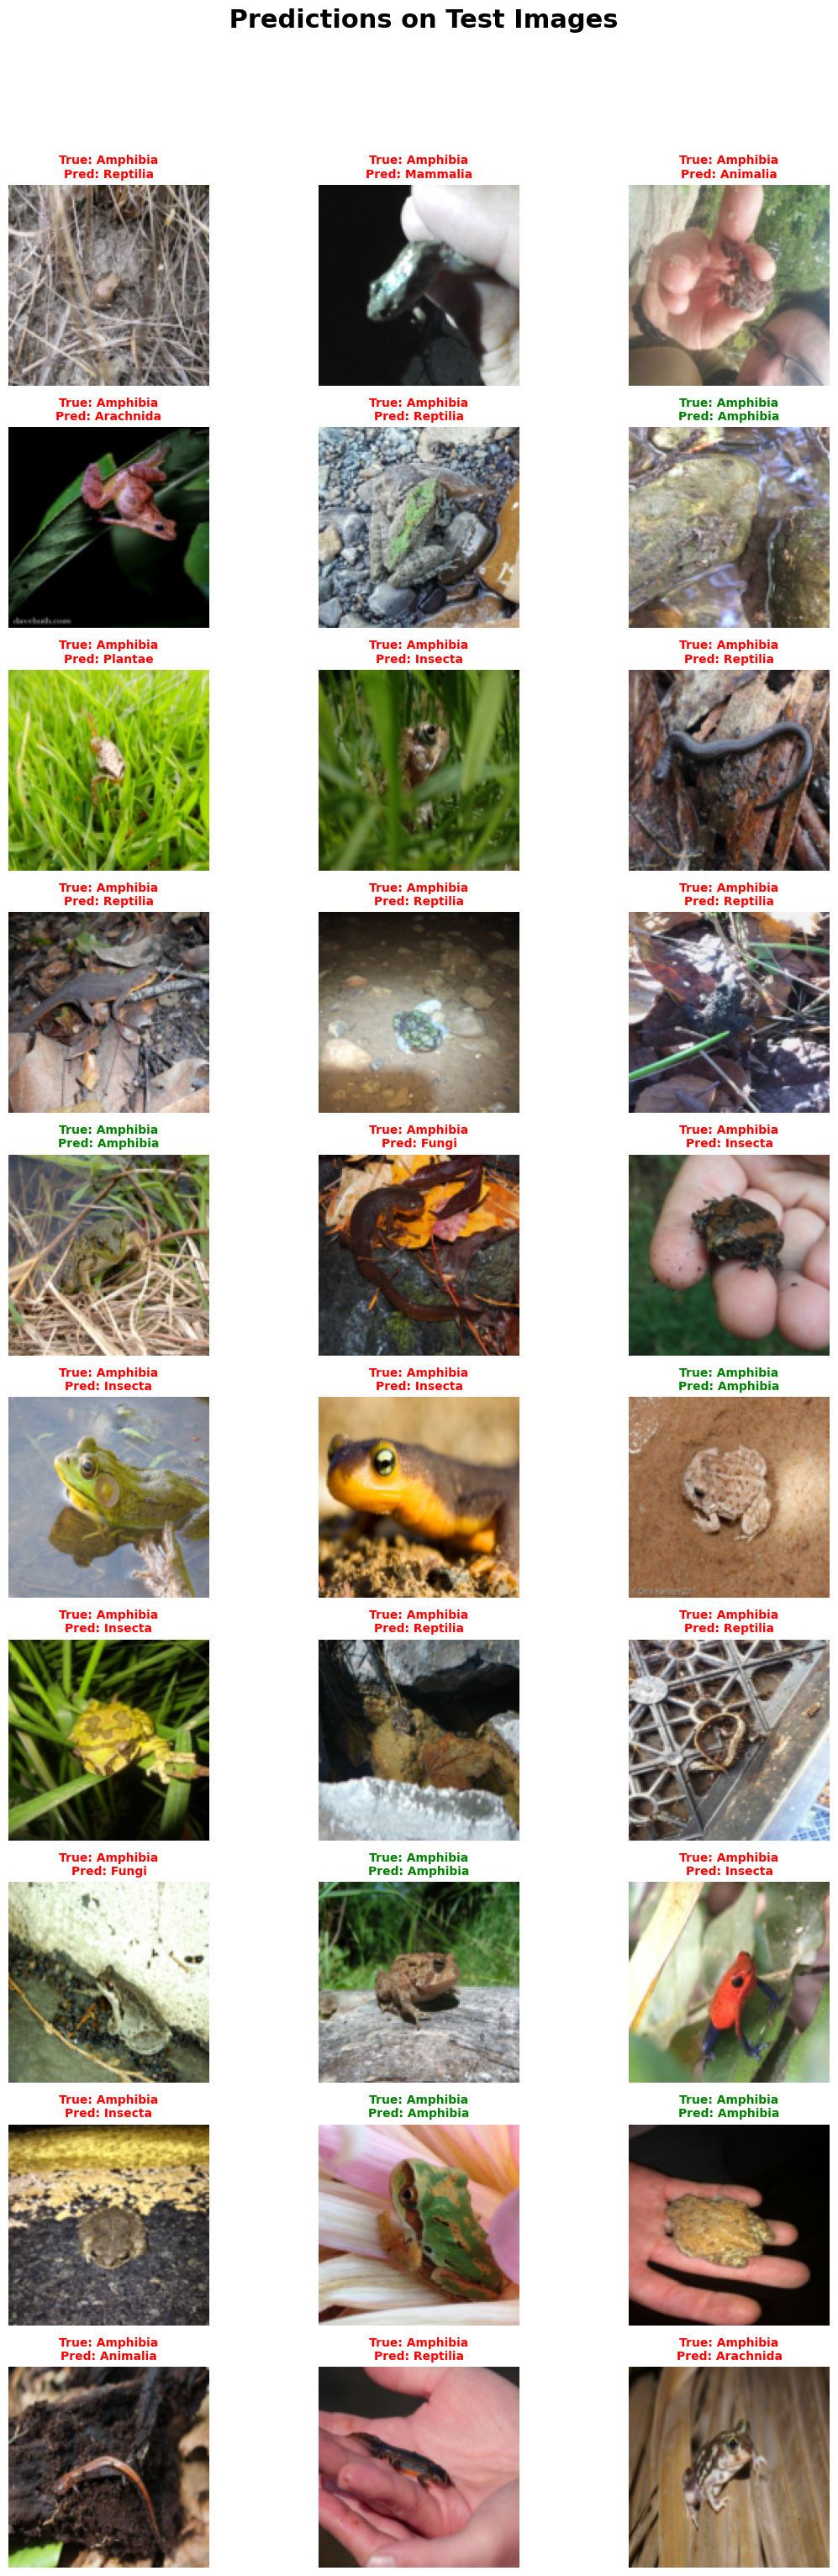

In [18]:
import matplotlib.pyplot as plt

# Load the model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Get a batch of test images
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Get model predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Move tensors to CPU for visualization
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

# Class names
class_names = test_dataset.classes

# Function to unnormalize images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

# Plot the 10x3 grid
fig, axes = plt.subplots(10, 3, figsize=(12, 30))
fig.suptitle(' Predictions on Test Images', fontsize=22, fontweight='bold', y=1.02)

for i in range(30):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    img = imshow(images[i])
    ax.imshow(img)
    true_label = class_names[labels[i]]
    pred_label = class_names[predicted[i]]
    
    if true_label == pred_label:
        title_color = 'green'
    else:
        title_color = 'red'
    
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=title_color, fontsize=10, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()